In [1]:
%matplotlib notebook
import numpy as np
import os
import matplotlib.pyplot as plt
import xgboost as xgb
import csv
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pandas as pd
import lightgbm as lgb
import sklearn
import seaborn as sns

## Load File 

In [2]:
train_file = pd.read_csv(r'C:\Users\wuhan\Desktop\train.csv')

test_file = pd.read_csv(r'C:\Users\wuhan\Desktop\test.csv')

train_num_points, train_num_attributes = train_file.shape
test_num_points, test_num_attributes = test_file.shape
print("There are {} data points, each with {} attributes in train.". format(train_num_points, train_num_attributes))
print("There are {} data points, each with {} attributes in test.". format(test_num_points, test_num_attributes))

There are 16784 data points, each with 30 attributes in train.
There are 5000 data points, each with 29 attributes in test.


### Check Attribites of Train and Test Files 

In [3]:
def check_attributes(Train_col, Test_col):
    Train_dif = [c for c in Train_col+Test_col if c not in Train_col]
    Test_dif = [c for c in Train_col+Test_col if c not in Test_col]
    print("columns not in Train File: ", Train_dif)
    print("columns not in Test File: ", Test_dif)

check_attributes(sorted(train_file.columns), sorted(test_file.columns))

columns not in Train File:  []
columns not in Test File:  ['price']


## Data Processing 
### Fill in Missing values

In [4]:
# Delete duplictaed ID
train = train_file.copy (deep=False)
train = train.drop_duplicates(subset=['listing_id'])

In [5]:
# drop text column
cols_to_drop =  ['description', 'category', 'features', 'accessories', 'indicative_price', "lifespan", "listing_id","eco_category"]
train = train.drop(columns = cols_to_drop)

In [6]:
percent_missing = train.isnull().sum() * 100 / len(train)
missing_value_df = pd.DataFrame({'column_name': train.columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True, ascending=False)
print(missing_value_df)
print (train.shape)

                         column_name  percent_missing
opc_scheme                opc_scheme        98.762554
original_reg_date  original_reg_date        98.098996
fuel_type                  fuel_type        79.238403
mileage                      mileage        22.214252
power                          power        13.934720
make                            make        12.876614
road_tax                    road_tax        12.840746
dereg_value              dereg_value         7.077953
coe                              coe         5.296509
curb_weight              curb_weight         3.461263
depreciation            depreciation         2.588474
arf                              arf         1.697752
reg_date                    reg_date         1.201578
manufactured            manufactured         1.159732
no_of_owners            no_of_owners         1.052128
engine_cap                engine_cap         0.316834
omv                              omv         0.245098
title                       

In [7]:
# Drop NA in "manufactured","no_of_owners", "engine_cap", "omv"
NA_to_drop = ["manufactured","no_of_owners", "engine_cap", "omv", "arf"]
train = train.dropna(subset=NA_to_drop)

In [8]:
# fill in "make"
make_replace = {'alfa':'alfa romeo', 'aston': 'aston martin', 'golden':  'golden dragon', 'land': 'land rover'}

train_make = train['title'].str.extract(r'(^\S*)')
train_make[0] = train_make[0].str.lower()
train_make[0] = train_make[0].replace(make_replace)

idx = train['make'].isnull().tolist()
idx_null = [i for i in range(len(idx)) if idx[i] == True]
train['make'].iloc[idx_null] = train_make[0].iloc[idx_null]
# print(train['make'])

In [9]:
# fill reg_date
ind = np.where(train['reg_date'].isnull())[0]
train["reg_date"].iloc[ind] = train["original_reg_date"].iloc[ind]
# print(ind)
train = train.drop(columns = 'original_reg_date')
train["Date_Used"] = pd.Timestamp.now().normalize() - pd.to_datetime( train['reg_date'])
train["Date_Used"]=train["Date_Used"].dt.days
# print(train["Date_Used"])

In [10]:
# opc_scheme
train = train.fillna(value={"opc_scheme":"non_opc"})
# fuel_type
index = np.where(train['transmission'] == "manual")[0]
train["fuel_type"].iloc[index] = "diesel"
train = train.fillna(value={"fuel_type":"petrol"})
# train['fuel_type'] = train['fuel_type'].fillna(train['fuel_type'].mode()[0])

C:\Users\wuhan\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [11]:
drop = ["reg_date","title"]
train = train.drop(columns = drop)

<IPython.core.display.Javascript object>


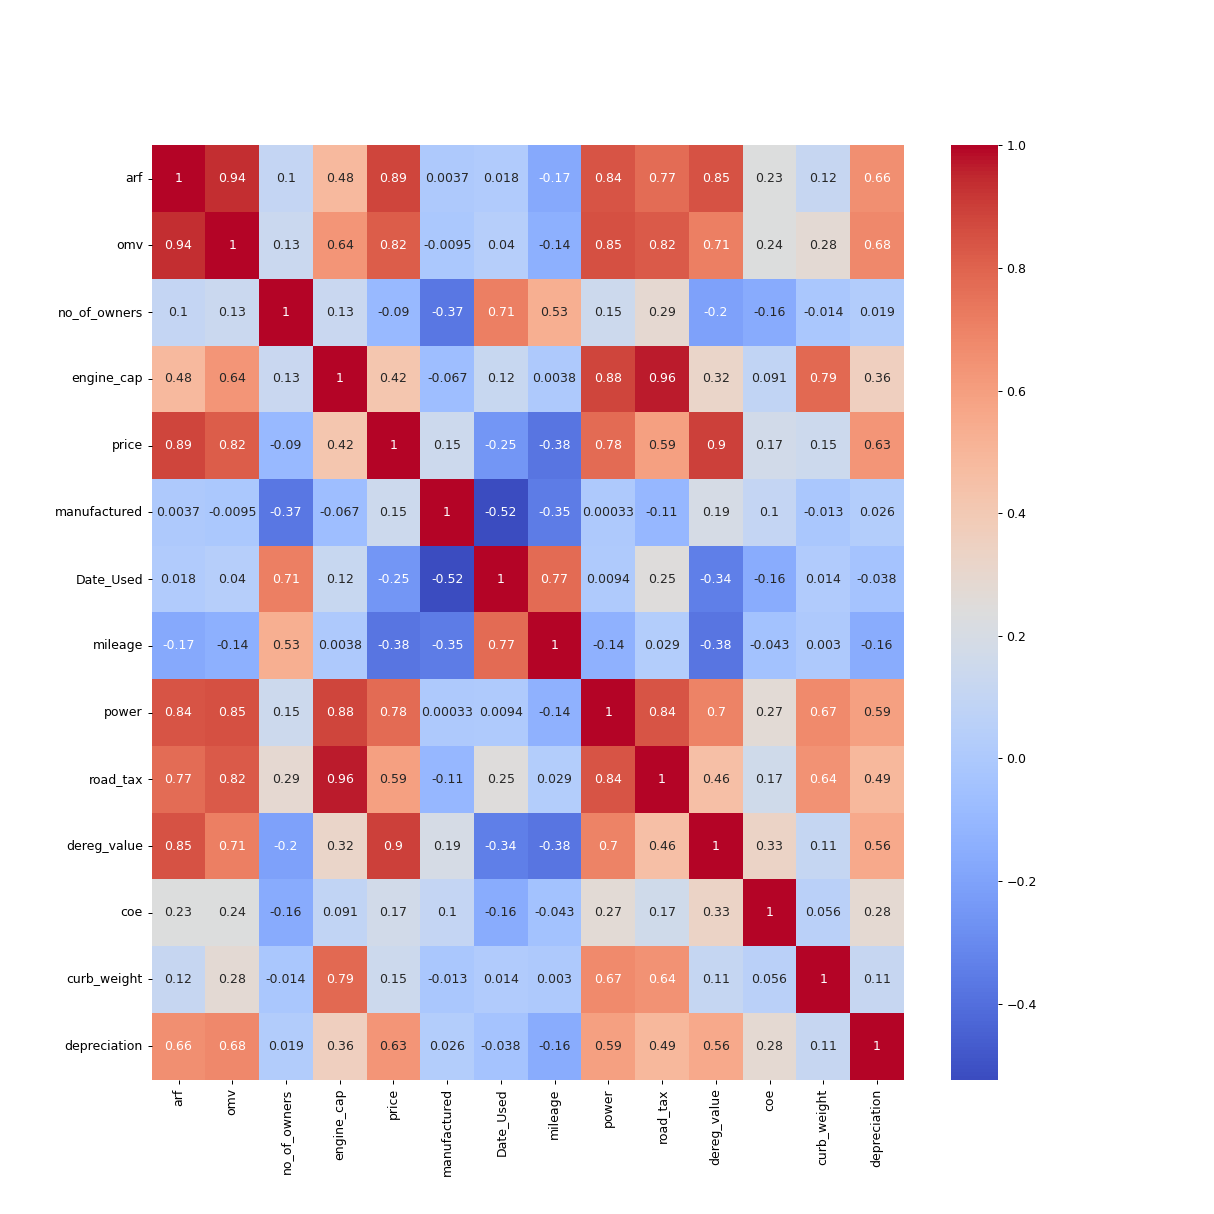

In [12]:
columns=["arf", "omv","no_of_owners", "engine_cap","price", "manufactured","Date_Used","mileage","power", "road_tax","dereg_value","coe","curb_weight","depreciation"]
plt.figure(figsize=(15,15))
sns.heatmap(train[columns].corr(),annot=True, cmap="coolwarm");

In [13]:
col_mean = ["mileage","power", "road_tax", "dereg_value", "coe", "curb_weight", "depreciation"]
train = train.fillna(value={i : train[i].mean() for i in col_mean}) 
# print(train["mileage"])

In [14]:
# Create Rating column
random_state = np.random.RandomState(0)
train["Rating"] = random_state.randint(1,100, size = train.shape[0])
# print(train["Rating"])

### Print Train_non_encoded.xlsx

In [15]:
# print none_encoded excel 
train.to_excel("Train_non_encoded.xlsx",encoding='utf-8',index=False)

### Factorize

In [16]:
# factorize column 
columns=['make','model','type_of_vehicle','fuel_type', 'transmission',"opc_scheme"]
train[columns] = train[columns].apply(lambda x: pd.factorize(x)[0])
# train.head()

### Binning and Smoothing

In [17]:
col_int = ["mileage", "price", "Date_Used", "manufactured", "curb_weight", "power", "engine_cap", "depreciation", "coe", "road_tax", "dereg_value", "omv", "arf", "price"]
# Transfer from float to int
for i in col_int:
    train[i] = train[i].astype(np.int32)
# print(train.head(50))
# pd.set_option('display.max_rows', 100)

In [18]:
col = ["mileage", "Date_Used","manufactured", "curb_weight", "power", "engine_cap", "depreciation", "coe", "road_tax", "dereg_value", "omv", "arf", "price"]
for i in col:
    a = np.int_(train[i].quantile(0.10))
    b = np.int_(train[i].quantile(0.20))
    c = np.int_(train[i].quantile(0.30))
    d = np.int_(train[i].quantile(0.40)) 
    e = np.int_(train[i].quantile(0.50))
    f = np.int_(train[i].quantile(0.60))
    g = np.int_(train[i].quantile(0.70))
    h = np.int_(train[i].quantile(0.80))
    max_value = np.round(train[i].max())
    price_range = {range(0, a): 1, range(a, b): 2, range(b, c): 3, range(c, d): 4, range(d, e): 5,range(e, f): 6,range(f, g): 7,range(g, h): 8, range(h, np.int_(max_value)+1): 9}
    train[i] = train[i].apply(lambda x: next((v for k, v in price_range.items() if x in k), 0))


In [19]:
# Price 
a = np.int_(train.price.quantile(0.25))
b = np.int_(train.price.quantile(0.50))
c = np.int_(train.price.quantile(0.75))
price_max = np.round(train["price"].max())
price_range = {range(0, a): 1, range(a, b): 2, range(b, c): 3, range(c, np.int_(price_max)+1): 4}
train["price"] = train["price"].apply(lambda x: next((v for k, v in price_range.items() if x in k), 0))

### Print Train_encoded.xlsx

In [20]:
# print updated excel
train.to_excel("Train_encoded.xlsx",encoding='utf-8',index=False)
# ew = pd.ExcelWriter('Train_modified.xlsx',options={'encoding':'utf-8'})
# train.to_excel(ew)